<a href="https://colab.research.google.com/github/DhayuIntan/Machine_Learning/blob/main/jobsheet-10/praktikum_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**
## RNN untuk Analisis Sentimen

### **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

### **Setup input pipeline**
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS.

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I actually quite enjoyed this show. Even as a youngster I was interested in all sports and that included horse racing. It was always going to be difficult to make a series based on racing corruption and at the same time get permission from the race tracks to record filming about this controversial subject. One episode I particularly remember centred around a horse expected to win a big race that looked a bit off colour. A syringe was found on the stable floor and everyone thought it had been drugged but nothing showed up in the blood tests. All too late they realised the horse hadnt been doped but had had its knee cartilage removed. Like running a car with no oil and the engine seizing up, the horse broke down with tragic consequences.'
 b'THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can\'t figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments,

### **Buat Teks Encoder**
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):


In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 157, 176, ...,   0,   0,   0],
       [  2,   1,  68, ...,   0,   0,   0],
       [  1,   1,  14, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:


*   Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
*   Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I actually quite enjoyed this show. Even as a youngster I was interested in all sports and that included horse racing. It was always going to be difficult to make a series based on racing corruption and at the same time get permission from the race tracks to record filming about this controversial subject. One episode I particularly remember centred around a horse expected to win a big race that looked a bit off colour. A syringe was found on the stable floor and everyone thought it had been drugged but nothing showed up in the blood tests. All too late they realised the horse hadnt been doped but had had its knee cartilage removed. Like running a car with no oil and the engine seizing up, the horse broke down with tragic consequences.'
Round-trip:  i actually quite enjoyed this show even as a [UNK] i was interested in all [UNK] and that [UNK] [UNK] [UNK] it was always going to be difficult to make a series based on [UNK] [UNK] and at the same time get [UNK] from the [UNK]

### **Buat Model**

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi.

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[0.01040835]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.01040835]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 100ms/step - loss: 0.6219 - accuracy: 0.5937 - val_loss: 0.4531 - val_accuracy: 0.7776
Epoch 2/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3945 - accuracy: 0.8226 - val_loss: 0.3769 - val_accuracy: 0.8266
Epoch 3/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3427 - accuracy: 0.8511 - val_loss: 0.3438 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3232 - accuracy: 0.8608 - val_loss: 0.3304 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3108 - accuracy: 0.8677 - val_loss: 0.3271 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3057 - accuracy: 0.8705 - val_loss: 0.3261 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3014 - accuracy: 0.8742 - val_loss: 0.3239 - val_accuracy

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3282 - accuracy: 0.8474
Test Loss: 0.32821744680404663
Test Accuracy: 0.8473600149154663


(0.0, 0.6381593257188797)

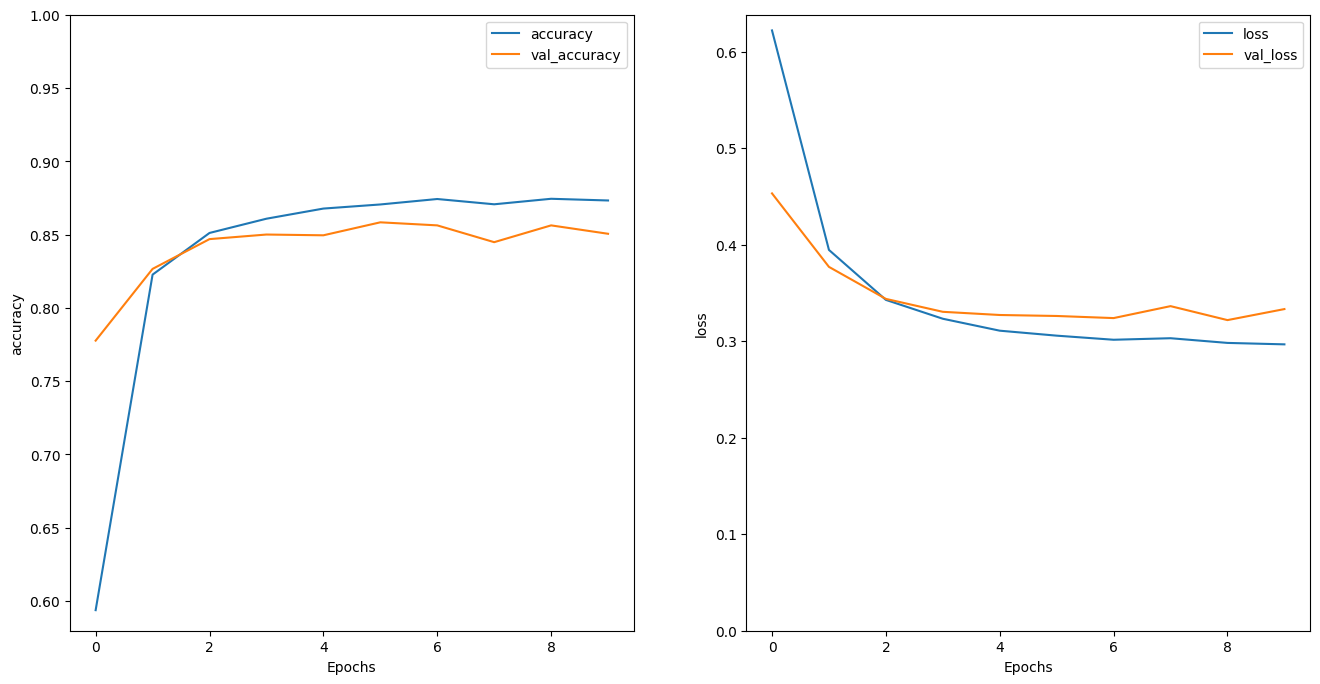

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### **Stack two or more LSTM layers**

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 148ms/step - loss: 0.6127 - accuracy: 0.5998 - val_loss: 0.4316 - val_accuracy: 0.8089
Epoch 2/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3836 - accuracy: 0.8344 - val_loss: 0.3511 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3357 - accuracy: 0.8577 - val_loss: 0.3293 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3194 - accuracy: 0.8648 - val_loss: 0.3388 - val_accuracy: 0.8375
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3111 - accuracy: 0.8688 - val_loss: 0.3179 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3059 - accuracy: 0.8706 - val_loss: 0.3309 - val_accuracy: 0.8359
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3066 - accuracy: 0.8692 - val_loss: 0.3238 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 47ms/step - loss: 0.3310 - accuracy: 0.8360
Test Loss: 0.33096733689308167
Test Accuracy: 0.8360400199890137


In [24]:
# Predict on a sample text without padding.
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.9324603]]


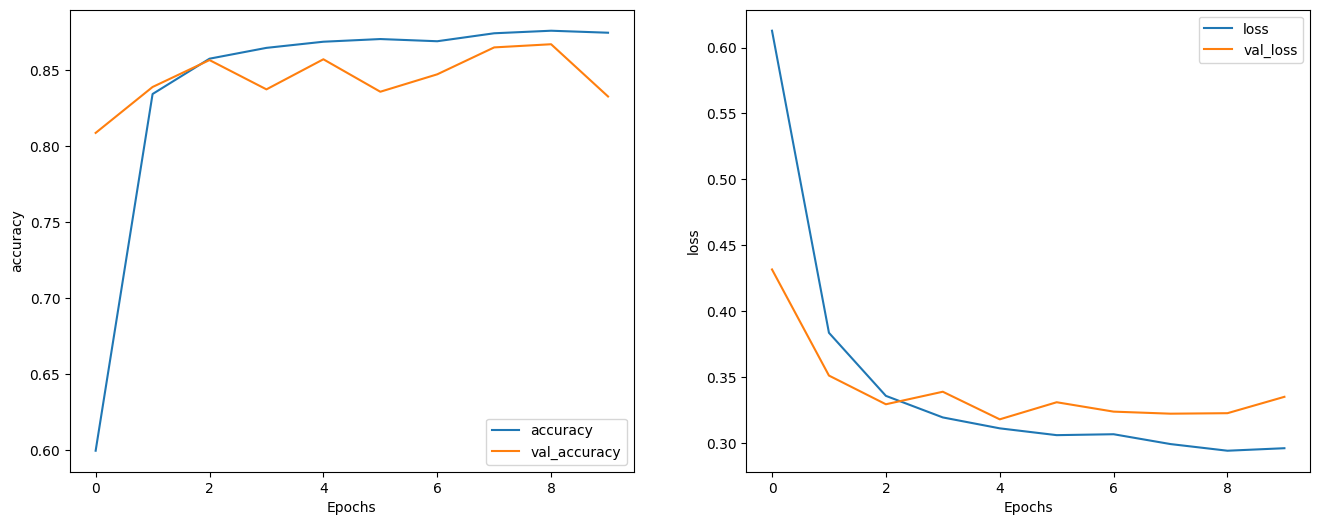

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')